# 特徴量エンジニアリング（TSFRESH）

In [1]:
!pip install -U pip -q
!pip install tsfresh -q
!pip install japanize_matplotlib -q

     |████████████████████████████████| 1.5MB 2.0MB/s 
     |████████████████████████████████| 85 kB 1.3 MB/s 
     |████████████████████████████████| 85 kB 2.6 MB/s 
     |████████████████████████████████| 4.1 MB 2.1 MB/s 


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
pd.set_option("display.max_columns", 100)

from tsfresh import extract_features
from tsfresh import select_features
from tsfresh import extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.examples.robot_execution_failures import load_robot_execution_failures
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures

import seaborn as sns
import japanize_matplotlib
import matplotlib.pyplot as plt
sns.set(font="IPAexGothic")
plt.style.use("ggplot")
%matplotlib inline

from google.colab import files

In [3]:
# データを読み込む
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [4]:
timeseries.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


In [5]:
y.head()

1    True
2    True
3    True
4    True
5    True
dtype: bool

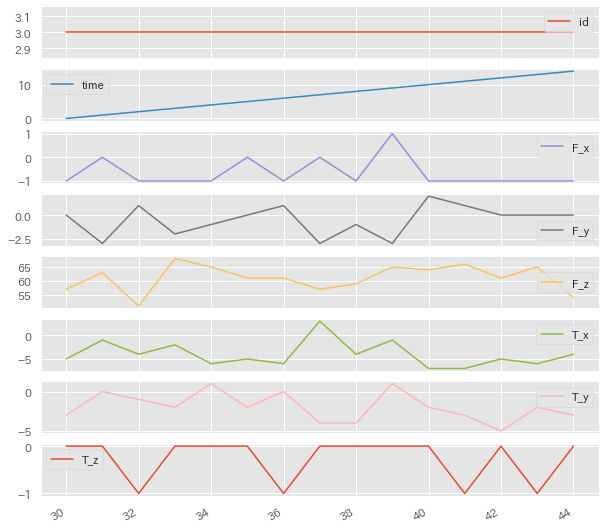

In [6]:
# 正常のデータをプロットしてみる
timeseries.loc[timeseries["id"] == 3].plot(subplots=True, sharex=True, figsize=(10, 10))
plt.show()

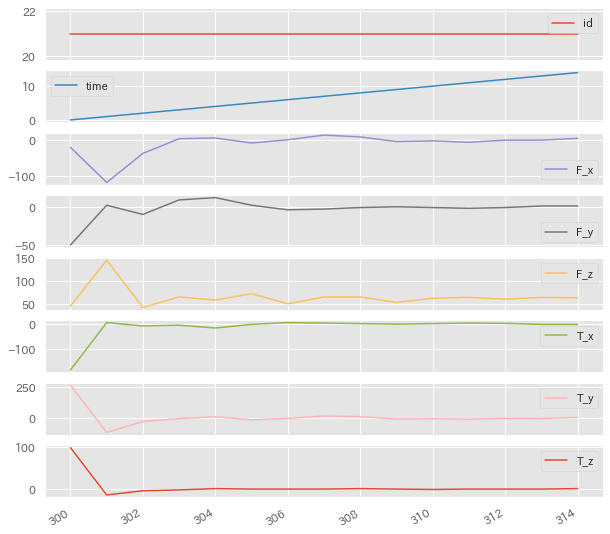

In [7]:
# 異常のデータをプロットしてみる
timeseries.loc[timeseries["id"] == 21].plot(
    subplots=True, sharex=True, figsize=(10, 10)
)
plt.show()

In [8]:
# 特徴量抽出してみる
extracted_features = extract_features(timeseries, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 5/5 [00:23<00:00,  4.64s/it]


In [9]:
# 抽出したデータを見てみる
print(f"行数：{extracted_features.shape[0]}, カラム数：{extracted_features.shape[1]}")

行数：88, カラム数：4578


In [10]:
# 抽出した特徴量を見てみる
extracted_features.columns.tolist()[:5]

['F_x__abs_energy',
 'F_x__absolute_sum_of_changes',
 'F_x__agg_autocorrelation__f_agg_"mean"__maxlag_40',
 'F_x__agg_autocorrelation__f_agg_"median"__maxlag_40',
 'F_x__agg_autocorrelation__f_agg_"var"__maxlag_40']

In [11]:
extracted_features.head()

variable,F_x__abs_energy,F_x__absolute_sum_of_changes,"F_x__agg_autocorrelation__f_agg_""mean""__maxlag_40","F_x__agg_autocorrelation__f_agg_""median""__maxlag_40","F_x__agg_autocorrelation__f_agg_""var""__maxlag_40","F_x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""mean""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""min""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""var""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""max""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""var""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""max""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""mean""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""min""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""var""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""max""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""mean""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""min""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""var""","F_x__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","F_x__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""","F_x__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""min""","F_x__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""var""","F_x__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","F_x__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""mean""","F_x__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""min""","F_x__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","F_x__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""","F_x__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","F_x__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""min""","F_x__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""var""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""min""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""var""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""max""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""mean""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""min""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""var""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""",...,T_z__range_count__max_1__min_-1,T_z__ratio_beyond_r_sigma__r_0.5,T_z__ratio_beyond_r_sigma__r_1,T_z__ratio_beyond_r_sigma__r_1.5,T_z__ratio_beyond_r_sigma__r_10,T_z__ratio_beyond_r_sigma__r_2,T_z__ratio_beyond_r_sigma__r_2.5,T_z__ratio_beyond_r_sigma__r_3,T_z__ratio_beyond_r_sigma__r_5,T_z__ratio_beyond_r_sigma__r_6,T_z__ratio_beyond_r_sigma__r_7,T_z__ratio_value_number_to_time_series_length,T_z__sample_entropy,T_z__skewness,T_z__spkt_welch_density__coeff_2,T_z__spkt_welch_density__coeff_5,T_z__spkt_welch_density__coeff_8,T_z__standard_deviation,T_z__sum_of_reoccurring_data_points,T_z__sum_of_reoccur

In [12]:
# 特徴量削減を実施
impute(extracted_features)
features_filtered = select_features(extracted_features, y)

In [13]:
# 削減したデータを見てみる
print(f"行数：{features_filtered.shape[0]}, カラム数：{features_filtered.shape[1]}")

行数：88, カラム数：626


In [14]:
# 抽出と削減を同時実施
features_filtered_direct = extract_relevant_features(
    timeseries, y, column_id="id", column_sort="time"
)

Feature Extraction: 100%|██████████| 5/5 [00:23<00:00,  4.68s/it]


In [15]:
# 同時実施で得たデータを見てみる
print(
    f"行数：{features_filtered_direct.shape[0]}, カラム数：{features_filtered_direct.shape[1]}"
)

行数：88, カラム数：626


In [16]:
# 2シリーズを抜き出して時系列のローリングテーブルを作成
df = timeseries.loc[timeseries["id"].isin([3, 4])].reset_index(drop=True)

In [17]:
# 先頭10行をみる
df.head(10)

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,3,0,-1,0,57,-5,-3,0
1,3,1,0,-3,63,-1,0,0
2,3,2,-1,1,51,-4,-1,-1
3,3,3,-1,-2,68,-2,-2,0
4,3,4,-1,-1,65,-6,1,0
5,3,5,0,0,61,-5,-2,0
6,3,6,-1,1,61,-6,0,-1
7,3,7,0,-3,57,3,-4,0
8,3,8,-1,-1,59,-4,-4,0
9,3,9,1,-3,65,-1,1,0


### 時系列特徴量抽出用のテーブル作成

In [18]:
# ローリングテーブル
df_rolled = roll_time_series(
    df, column_id="id", column_sort="time", max_timeshift=3, min_timeshift=3
)
df_rolled.head(10)

Rolling: 100%|██████████| 5/5 [00:00<00:00, 45.12it/s]


,id,time,F_x,F_y,F_z,T_x,T_y,T_z
56,"id=3,timeshift=10",7,0,-3,57,3,-4,0
57,"id=3,timeshift=10",8,-1,-1,59,-4,-4,0
58,"id=3,timeshift=10",9,1,-3,65,-1,1,0
59,"id=3,timeshift=10",10,-1,2,64,-7,-2,0
64,"id=3,timeshift=11",8,-1,-1,59,-4,-4,0
65,"id=3,timeshift=11",9,1,-3,65,-1,1,0
66,"id=3,timeshift=11",10,-1,2,64,-7,-2,0
67,"id=3,timeshift=11",11,-1,1,66,-7,-3,-1
72,"id=3,timeshift=12",9,1,-3,65,-1,1,0
73,"id=3,timeshift=12",10,-1,2,64,-7,-2,0


In [19]:
# ローリングテーブルで特徴量作成
df_features = extract_features(df_rolled, column_id="id", column_sort="time")
df_features.head()

Feature Extraction: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


variable,F_x__abs_energy,F_x__absolute_sum_of_changes,"F_x__agg_autocorrelation__f_agg_""mean""__maxlag_40","F_x__agg_autocorrelation__f_agg_""median""__maxlag_40","F_x__agg_autocorrelation__f_agg_""var""__maxlag_40","F_x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""mean""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""min""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""var""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","F_x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""max""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""var""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""max""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""mean""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""min""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""var""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""max""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""mean""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""min""","F_x__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""var""","F_x__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","F_x__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""","F_x__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""min""","F_x__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""var""","F_x__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","F_x__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""mean""","F_x__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""min""","F_x__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","F_x__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""","F_x__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","F_x__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""min""","F_x__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""var""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""min""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""var""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""max""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""mean""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""min""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""var""","F_x__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""",...,T_z__range_count__max_1__min_-1,T_z__ratio_beyond_r_sigma__r_0.5,T_z__ratio_beyond_r_sigma__r_1,T_z__ratio_beyond_r_sigma__r_1.5,T_z__ratio_beyond_r_sigma__r_10,T_z__ratio_beyond_r_sigma__r_2,T_z__ratio_beyond_r_sigma__r_2.5,T_z__ratio_beyond_r_sigma__r_3,T_z__ratio_beyond_r_sigma__r_5,T_z__ratio_beyond_r_sigma__r_6,T_z__ratio_beyond_r_sigma__r_7,T_z__ratio_value_number_to_time_series_length,T_z__sample_entropy,T_z__skewness,T_z__spkt_welch_density__coeff_2,T_z__spkt_welch_density__coeff_5,T_z__spkt_welch_density__coeff_8,T_z__standard_deviation,T_z__sum_of_reoccurring_data_points,T_z__sum_of_reoccur

In [20]:
# 単一時系列の場合、ターゲットとローリングテーブル一括で作れる
df_shift, y = make_forecasting_frame(
    df["T_x"], kind="torque", max_timeshift=3, rolling_direction=1
)
df_shift.loc[df_shift["id"].isin(["id=id,timeshift=3", "id=id,timeshift=4"])]

Rolling: 100%|██████████| 5/5 [00:00<00:00, 20.76it/s]


,id,time,value,kind
6,"id=id,timeshift=3",0,-5,torque
7,"id=id,timeshift=3",1,-1,torque
8,"id=id,timeshift=3",2,-4,torque
10,"id=id,timeshift=4",1,-1,torque
11,"id=id,timeshift=4",2,-4,torque
12,"id=id,timeshift=4",3,-2,torque


In [21]:
y.head()

1   -1
2   -4
3   -2
4   -6
5   -5
Name: value, dtype: int64